# Calculate Charging Time per Day

Read the database for BB1

If the system current is negative for an interval then assumes the system is charging.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl

Data = pd.DataFrame()
Site = 'BB/'
Dir = 'W:/'
sub_dir = 'Met/'
Time_Trace = 'clean_tv'
Traces = ['SYS_Batt_DCCurrent_Avg','SYS_PBox_Batt_Volt_Avg']

Filter_NA = [-30,5]

for year in range (2016,2023):
    filename = f'{Dir}{str(year)}/{Site}{sub_dir}{Time_Trace}'
    with open(filename, mode='rb') as file:
        Time = np.fromfile(file, 'float64')
        Time = pd.to_datetime(Time-719529,unit='D')
            
        D_trace = {}
        for Trace in Traces:
            filename = f'{Dir}{str(year)}/{Site}/{sub_dir}{Trace}'
            with open(filename, mode='rb') as file:
                trace = np.fromfile(file, 'float32')
                D_trace[Trace]=trace
        df = pd.DataFrame(index=Time,data=D_trace)
        Data = pd.concat([Data,df])


Data = Data.dropna(axis=0, how='all')
# return(Data)
Data.to_csv('BB1_Power_History.csv')

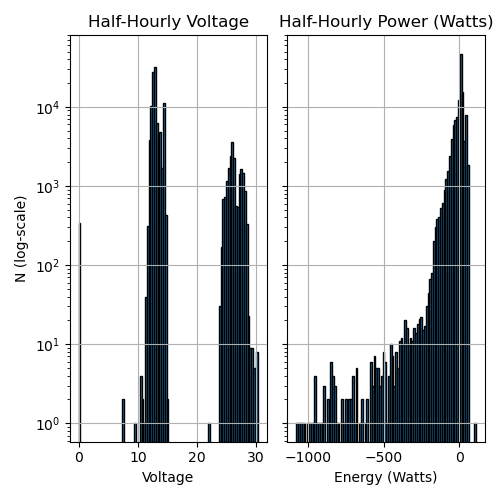

In [71]:
Data = pd.read_csv('BB1_Power_History.csv',parse_dates={'Date':[0]},index_col=['Date'])
Data = Data.rename(columns={
    'SYS_Batt_DCCurrent_Avg':'Current_amps',
    'SYS_PBox_Batt_Volt_Avg':'Voltage'
    })

Data['Energy_Watts'] = (Data['Current_amps']*Data['Voltage'])*.8

# Times when Energy/current are negative are periods when system is charging
Data['Charging_Hours']=Data['Energy_Watts']*0
Data.loc[Data['Energy_Watts']<0,'Charging_Hours']=1

# Find duration of stretches without charging
y = (Data['Charging_Hours']-1)*-1
Data['No_Power'] = (y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1))/2

fig,axes=plt.subplots(1,2,figsize=(5,5),sharey=True)

ax=axes[0]
Data["Voltage"].hist(ax=ax,edgecolor='k',bins=100)
ax.set_xlabel('Voltage')
ax.set_ylabel('N (log-scale)')
ax.set_title('Half-Hourly Voltage')
ax.set_yscale('log')

# Filter out erroneously low voltages is 0
Data.loc[Data['Voltage']<5,'Energy_Watts']=np.nan

ax=axes[1]
Data["Energy_Watts"].hist(ax=ax,edgecolor='k',bins=100)
ax.set_xlabel('Energy (Watts)')
# ax.set_ylabel('N (30 min Intervals)')
ax.set_title('Half-Hourly Power (Watts)')
# ax.set_yscale('log')

plt.tight_layout()



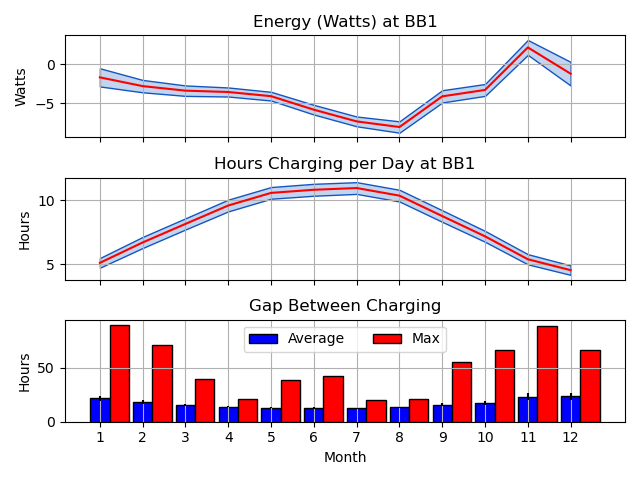

In [79]:

def byInterval(df,x,y,bins=None,agg='mean'):
    if isinstance(df.index, pd.DatetimeIndex):
        Set = df.resample(x).agg(agg)
        Set['std'] = df.resample(x).std()[y]
        Set['c'] = df.resample(x).count()[y]
    else:
        if bins is None:
            bins = 10
        df['bins'] = pd.cut(df[x],bins=bins)
        df[f"{x}_bins"] = df['bins'].apply(lambda x: x.mid.round())
        df = df.drop('bins',axis=1)
        Set = df.groupby(f'{x}_bins').agg(agg,numeric_only=True)
        Set['std'] = df.groupby(f'{x}_bins').std()[y]
        Set['c'] = df.groupby(f'{x}_bins').count()[y]
    Set['CI95'] = Set['std']/(Set['c']**.5)*1.96
    return(Set[[y,'std','c','CI95']])

Data['Month']=Data.index.month

fig,axes=plt.subplots(3,sharex=True)
ax = axes[1]
Monthly = byInterval(Data.reset_index(),'Month','Charging_Hours',bins=12,agg='sum')

Monthly['Charging_Hours']=Monthly['Charging_Hours']/Monthly['c']*24
Monthly['CI95']=Monthly['CI95']*48


ax.fill_between(Monthly.index,Monthly['Charging_Hours']-Monthly['CI95'],Monthly['Charging_Hours']+Monthly['CI95'],
            facecolor='#1356c240',edgecolor='#1356c2')
ax.plot(Monthly.index,Monthly['Charging_Hours'],color='r')

ax.set_ylabel('Hours')
# ax.set_xlabel('Month')
ax.set_title('Hours Charging per Day at BB1')
ax.grid()

ax = axes[0]
# Assume BBS will use 15 W less power
offset = 15
# Correct for smaller array at BBS (Factory of 4 is temporary over estimate)
ratio = 4
Data['Energy_Watts_Scaled'] = (Data['Energy_Watts'] - offset)/ratio

Monthly = byInterval(Data.reset_index(),'Month','Energy_Watts',bins=12,agg='mean')

ax.fill_between(Monthly.index,Monthly['Energy_Watts']-Monthly['CI95'],Monthly['Energy_Watts']+Monthly['CI95'],
            facecolor='#1356c240',edgecolor='#1356c2')
ax.plot(Monthly.index,Monthly['Energy_Watts'],color='r')
ax.set_ylabel('Watts')
ax.set_title('Energy (Watts) at BB1')
ax.grid()

Data.loc[Data['No_Power']<=0,'No_Power']=np.nan
Data['No_Power'].describe()

Daily = Data.resample('d').max()[['No_Power','Month']]

Monthly = byInterval(Daily.reset_index(),'Month','No_Power',bins=12,agg='mean')

Monthly['Max_No_Power'] = Data.groupby(Data.index.month).max()['No_Power']

Monthly.index=Monthly.index.categories
Monthly['CI95']*=2

ax = axes[2]
ax.bar(Monthly.index,Monthly['No_Power'],yerr=Monthly['CI95'],width=.45,edgecolor='k',color='blue',label='Average')
ax.bar(Monthly.index+.45,Monthly['Max_No_Power'],width=.45,edgecolor='k',color='Red',label='Max')
ax.legend(ncol=2,loc=9)
ax.set_ylabel('Hours')
ax2.set_ylabel('Days')
ax.set_title('Gap Between Charging')
ax.set_xlabel('Month')
ax.grid()

ax.set_xticks(np.arange(1,13))
plt.tight_layout()


# Power Calculator

In [126]:
Batt_Voltage = 12
Batt_Amp_Hours = 35	
Batt_Weight_KG = 14.3 # Estimated from here - https://www.powerstream.com/Size_SLA.htm
Batt_per_Sequence = 1 # Can wire in sequence first to increase voltage - set to 1 = not in sequence
Batt_Sequences_in_Parallel = 6 #	Can wire in parallel to increase amperage
Discharge_Limit = .5 # Don't draw current below 50%
#Total Power Supply
N_Batt = Batt_Sequences_in_Parallel*Batt_per_Sequence
print('Number of Batteries', np.round(N_Batt,2))
Total_Batt_Weight = Batt_Weight_KG*N_Batt
print('Weight of Batteries', np.round(Total_Batt_Weight,2))
Supply_Voltage = Batt_Voltage*Batt_per_Sequence
Supply_Amp_Hours = Batt_Amp_Hours*Batt_Sequences_in_Parallel
print('Total Amp Hours', np.round(Supply_Amp_Hours,2))
Supply_Amp_Hours_Available = Supply_Amp_Hours*Discharge_Limit
print('Amp Hours Available', np.round(Supply_Amp_Hours_Available,2))
Days_to_Depletion = Supply_Amp_Hours_Available/System_Demand_Amps_per_Day
print(f'Days to {str(int(Discharge_Limit*100))}% Discharge Without Charge', np.round(Days_to_Depletion,1))

Number of Batteries 6
Weight of Batteries 85.8
Total Amp Hours 210
Amp Hours Available 105.0
Days to 50% Discharge Without Charge 3.8


## Charging Capacity

In [128]:
# Solar Panel Specs
Panel_Watts = 160 # Factory Rating
Panel_Voltage = 21
Charger_Voltage = 14.5
Panel_per_Sequence = 1 # Can wire in sequence first to increase voltage - set to 1 = not in sequence
Panel_Sequences_in_Parallel = 3 #	Can wire in parallel to increase amperage
Panel_Array_Voltage = Panel_Voltage*Panel_per_Sequence

Efficiency_Coef = .01 # Assume a continuous % drop / year
Panel_Age = 10
Panel_Efficiency = 1-(Efficiency_Coef*Panel_Age)

# Output of Panels (Watts pre panel x number of panels x efficiency)
Max_Output_Watts=Panel_Watts * Panel_per_Sequence * Panel_Sequences_in_Parallel * Panel_Efficiency


# Charger Specs
Charger_Max_Current = 60 # Amps
Charging_Efficiency = 0.8 # Assume charging is 80% efficient
Amps_In = (Max_Output_Watts)/Panel_Array_Voltage
if Amps_In > Charger_Max_Current:
    print('Waring - Current Input May Exceed Capacity of Charger!!')

# Calculate energy output from charger after voltage conversion
Watts_Out = Amps_In*Charger_Voltage*Charging_Efficiency

print('Max Input from Panels in Watts ',Max_Output_Watts)
print('Charger Input Voltage ',Panel_Array_Voltage)
print('Charger Output Voltage ',Charger_Voltage)
print('Max Output from Charger in Watts ',np.round(Watts_Out,1))


Max Input from Panels in Watts  432.0
Charger Input Voltage  21
Charger Output Voltage  14.5
Max Output from Charger in Watts  238.6
Max Output less Demand in Watts  224.4
Hours of Full Sun Needed for "Complete" Recharge from Depletion 6.8


## Instrument Power Demands

In [129]:
# Operating voltage
Inst_Voltage = 12.4

# in Watts - Can take a Range each instrument - otherwise just repeat estimate
Inst_Power_Draw = np.array([
    [8,18],#LI 7500: https://www.licor.com/env/support/LI-7500RS/topics/specifications.html - old one may be more
    [1.2,1.2] # CSAT3: https://www.campbellsci.ca/csat3 - at 20 hz
    ]) 

System_Demand_Watts=Inst_Power_Draw.mean(axis=-1).sum()

System_Demand_Amps_per_Day = System_Demand_Watts/Inst_Voltage*24

print('Mean System Demand Watts: ',np.round(System_Demand_Watts,2))
print('Total System Demand Amps per Day: ',np.round(System_Demand_Amps_per_Day,2))



Watts_Out_Adjusted = Watts_Out-System_Demand_Watts

print('Max Output less Demand in Watts ',np.round(Watts_Out_Adjusted,1))
print('Hours of Full Sun Needed for "Complete" Recharge from Depletion',
    np.round(Supply_Amp_Hours_Available/(Watts_Out_Adjusted/Charger_Voltage),1))

Mean System Demand Watts:  14.2
Total System Demand Amps per Day:  27.48
Max Output less Demand in Watts  224.4
Hours of Full Sun Needed for "Complete" Recharge from Depletion 6.8


# Supply/Demand Estimates

Estimated power generation Averaged by month
Negative 'Balance' indicates an anticipated daily deficit - based on conservative assumptions


,Charging_Time,Supply_Watts,Balance
Month_bins,,,
1.0,0.05,11.97,-2.23
2.0,0.07,15.70,1.50
3.0,0.09,19.10,4.90
4.0,0.10,22.46,8.26
5.0,0.11,24.77,10.57
6.0,0.11,25.34,11.14
7.0,0.11,25.66,11.46
8.0,0.11,24.26,10.06
9.0,0.09,20.53,6.33


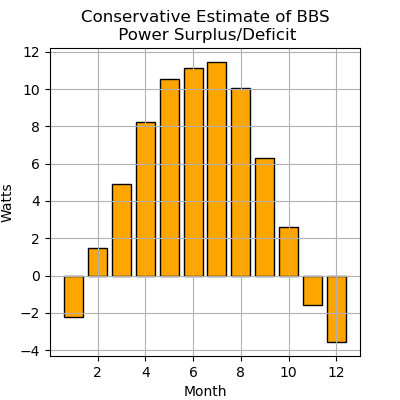

In [134]:
Monthly = byInterval(Data.reset_index(),'Month','Charging_Hours',bins=12)#,agg='sum')
Monthly['Charging_Hours']=Monthly['Charging_Hours']#/Monthly['c']*24
Monthly['CI95']=Monthly['CI95']#*48

Scale = .25 # Assume a % of sun shine compared to BB1 to account for shading
Energy_by_Month = (Monthly[['Charging_Hours']].astype('float64')*Scale)
Energy_by_Month = Energy_by_Month.rename(columns={
    'Charging_Hours':'Charging_Time'
})

Energy_by_Month['Supply_Watts'] = Watts_Out_Adjusted*Energy_by_Month['Charging_Time']

Energy_by_Month['Balance'] = Energy_by_Month['Supply_Watts']-System_Demand_Watts

fig,ax=plt.subplots(figsize=(4,4))
ax.bar(Energy_by_Month.index,Energy_by_Month['Balance'],edgecolor='k',color='orange')
ax.set_ylabel('Watts')
ax.set_title('Conservative Estimate of BBS\n Power Surplus/Deficit')
ax.grid()
ax.set_xlabel('Month')

print("Estimated power generation Averaged by month")
print("Negative 'Balance' indicates an anticipated daily deficit - based on conservative assumptions")
Energy_by_Month.round(2)
